# Try computing an independent priming probability plot for each timepoint 
- Spike in lymphoid for CS10-11
# current Solve for fate probabilities towards all terminal states
- use a cricular projection of the data
- try subsetting by stage at end

# We try using a background organ-state to increase the resolution of rarelineages

# Solve for Clara etal

In [1]:
import sys
import subprocess

%matplotlib inline
from collections import Counter
from collections import defaultdict
import scanpy as sc
import pandas as pd
import pickle as pkl
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re
import glob
import os
import sys
from numpy import cov
import scipy.cluster.hierarchy as spc
import seaborn as sns; sns.set(color_codes=True)
from sklearn.linear_model import LogisticRegression
import sklearn
from pathlib import Path
from matplotlib import rcParams
rcParams['figure.figsize'] = 10,60

import scvelo as scv
import scanpy as sc
import cellrank as cr
import numpy as np

scv.settings.verbosity = 3
scv.settings.set_figure_params("scvelo")
cr.settings.verbosity = 2

In [4]:
adata = sc.read('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Submission_figure_scripts/F3/HSPC_comparison_dotplots/transition_state_prob_overtime_ipsc/Clara_IPSC/scvi_outs_terminal_states/run_A2_V9_IPSC_clara_Haem_traj_scvi_norm_.h5ad')

# Create stage mapper

In [11]:
adata.obs['SampleTime'] = adata.obs['SampleName'].str.replace('Day','')
adata.obs['SampleTime'] = adata.obs['SampleTime'].str.replace('EB','')
adata.obs['SampleTime'] = adata.obs['SampleTime'].str.replace('iPSC','')
adata.obs['SampleTime'] = adata.obs['SampleTime'].str.replace('DC','')

In [12]:
stages = [
'00',
 '01',
 '02',
 '04',
 '05',
 '07',
 '09',
 '11',
 '14',
 '16',
 '18',
 '21',
 '23',
 '25',
 '28',
 '31',
 '31plus1pre',
 '31plus4pre',
 '31plus7pre']
stage_groups = [
'00',
 '01',
 '02',
 '04',
 '05',
 '07',
 '09',
 '11',
 '14',
 '16',
 '18',
 '21',
 '23',
 '25',
 '28',
 '31',
 '32',
 '35',
 '37']
stage_groups_order = stage_groups
stage_mapper = dict(zip(stages,stage_groups))
adata.obs['stage_groups'] = adata.obs['SampleTime'].astype(str).map(stage_mapper)
adata.obs['stage_groups'] = adata.obs['stage_groups'].astype('category').cat.reorder_categories(stage_groups_order)

In [13]:
adata.obs['LR_assignment_v2'] = adata.obs['LR_assignment_v2'].astype(str)
pred_out = pd.read_csv('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_310122_notebooks/fig3_Macrophages/Process_IPSC_mac_data/IPSC_DC_lin_use_this/V5_pred_out_QC_HM_IPSC_YS.csv',index_col = 0)
adata.obs['stage_groups'] = adata.obs['stage_groups'].astype(float)
adata.obs.loc[((adata.obs['stage_groups']<7) & (adata.obs.index.str.replace('-2','').isin(pred_out.index))),'LR_assignment_v2']  = pred_out.loc[pred_out.index.isin(adata.obs.loc[adata.obs['stage_groups']<7].index.str.replace('-2','')),'orig_labels'].values
adata.obs['LR_assignment_v2'] = adata.obs['LR_assignment_v2'].astype(str)
adata.obs.loc[adata.obs.index.isin(pred_out[pred_out['orig_labels'].isin(['PrimitiveStreak_IPSC'])].index),'LR_assignment_v2'] = 'PrimitiveStreak_IPSC'

adata.obs['LR_assignment_v2'] = adata.obs['LR_assignment_v2'].astype(str)
adata.obs.loc[adata.obs.index.isin(pred_out[pred_out['orig_labels'].isin(['EmergentMesoderm_IPSC'])].index),'LR_assignment_v2'] = 'EmergentMesoderm_IPSC'

In [18]:
adata.obs.to_csv('./clara_haem_lin.csv')

# Update annots

In [19]:
adata.obs['cell_labels_lvl_mixed'] = adata.obs['cell_labels_lvl3'].copy()
#sorted(list(adata.obs['LR_assignment_v2'].unique()))

<ipython-input-19-9112536f5f6e>:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs['cell_labels_lvl_mixed'] = adata.obs['cell_labels_lvl3'].copy()


In [20]:
# adata.write('/nfs/team205/ig7/work_backups/backup_210306/projects/YS/YS_030522_notebooks/Submission_figure_scripts/F3/HSPC_comparison_dotplots/transition_state_prob_overtime_ipsc/Clara_IPSC/IPSC_clara_HAEM_raw.h5ad')

# Manually set macrostates

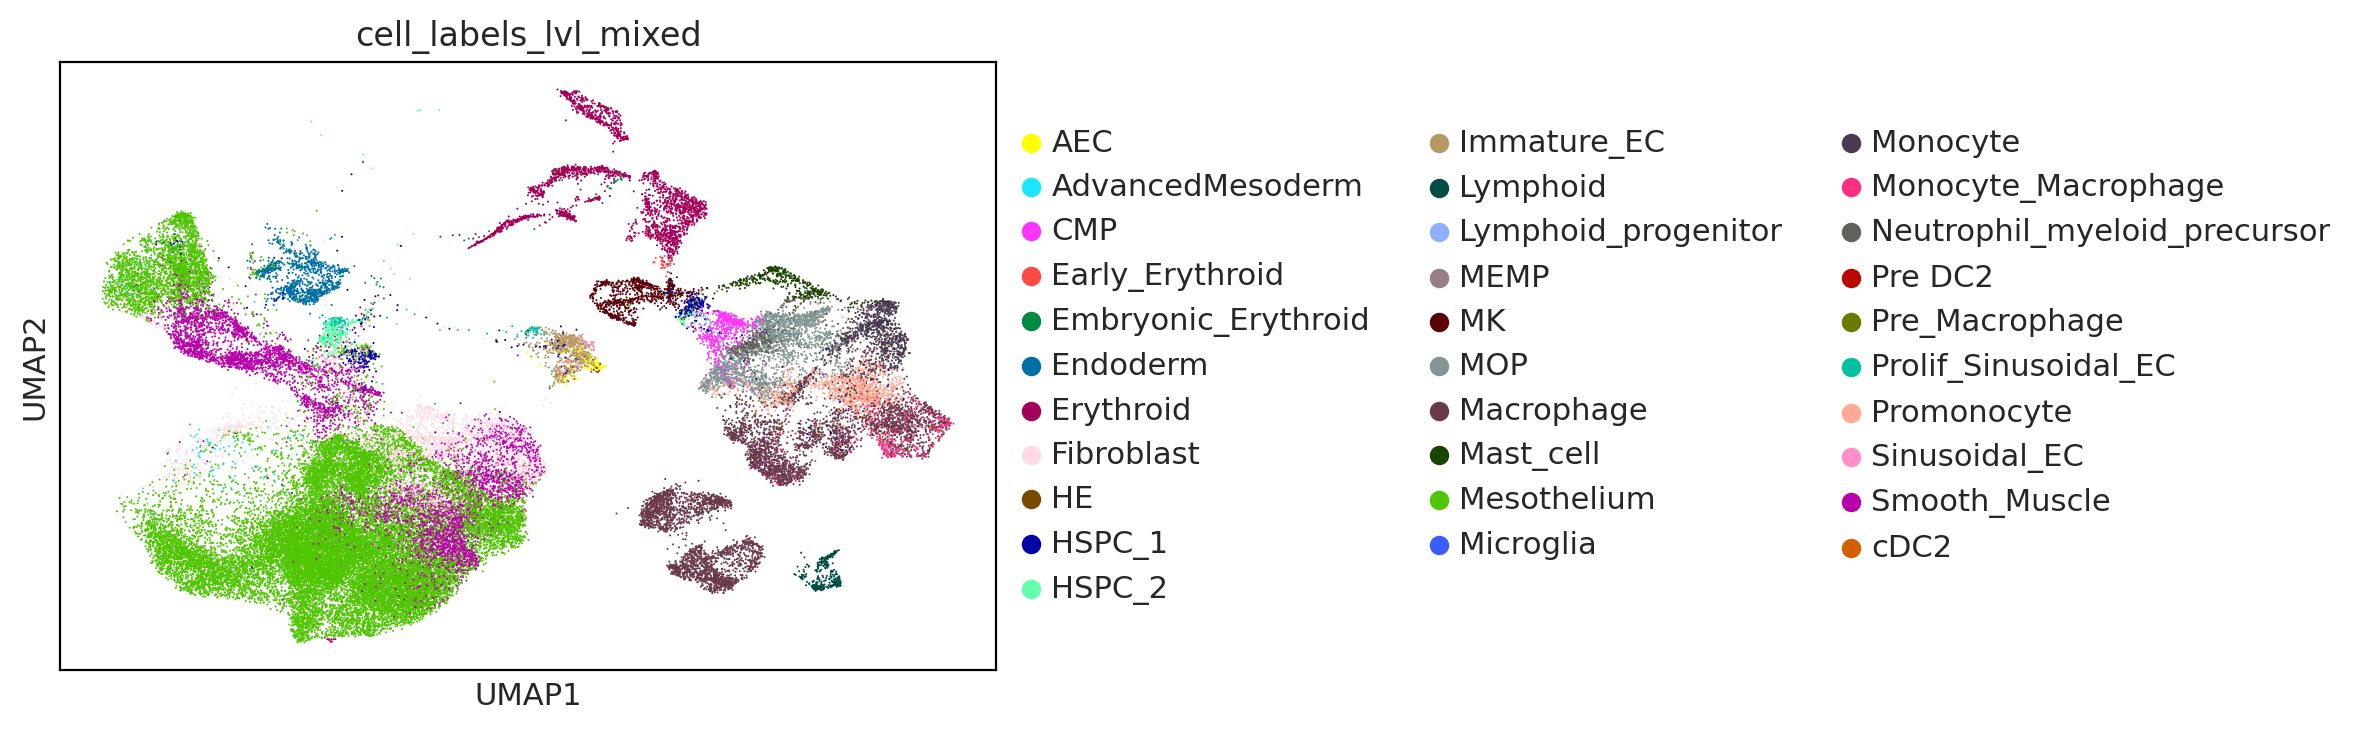

In [21]:
sc.pl.umap(adata,color =['cell_labels_lvl_mixed'] )

# subsample

In [22]:
# cat1 = 'cell_labels_lvl_mixed'
# cat2 = 'stage_groups'

# data = adata.obs[:]

# counts = (pd.DataFrame(data[cat1].value_counts()))
# mean = np.mean(counts[cat1])
# std = np.std(counts[cat1])
# pvals = scipy.stats.norm.sf(counts[cat1], loc=mean, scale=std)
# counts['pvals'] = pvals
# cat_down = list(counts[cat1][counts['pvals']<0.05].index)
# cat_down

# plt.hist(data[cat1])
# plt.xticks(rotation=90)

# prop = 0.2

# data[cat1] = data[cat1].astype(str)
# data = data[data[cat1].isin(cat_down)]
# df = data.groupby([cat1,cat2]).sample(frac=prop,replace=True)#n=int(mean)
# print(cat_down)
# cat_rm = data[data[cat1].isin(cat_down)]
# cat_rm = cat_rm[~cat_rm.index.isin(df.index)]
# adata = adata[~adata.obs.index.isin(cat_rm.index)]
# (pd.DataFrame(adata.obs[cat1].value_counts()))
# plt.hist(adata.obs[cat1])
# plt.xticks(rotation=90)

In [23]:
# cat1 = 'LR_assignment_v2'
# cat2 = 'stage_groups'
# data2= adata.obs
# grouped = data2.groupby([cat1,cat2])
# df = grouped.apply(lambda x: x.sample(frac=0.2))
# df = df.droplevel([cat1,cat2])
# remove = data2.index[~data2.index.isin(df.index)]
# adata = adata[~adata.obs.index.isin(remove)]
# adata 

In [24]:
adata.obs['cell_labels_lvl_mixed']

F61_Liver_CD45+_FCAImmP7862084_AAACCTGGTACCGTAT-0    Macrophage
F61_Liver_CD45+_FCAImmP7862084_AAACCTGGTCGCATCG-0            MK
F61_Liver_CD45+_FCAImmP7862084_AAACCTGTCTGGTGTA-0    Macrophage
F61_Liver_CD45+_FCAImmP7862084_AAACGGGTCCAATGGT-0            MK
F61_Liver_CD45+_FCAImmP7862084_AAACGGGTCGCCAAAT-0            MK
                                                        ...    
TTTACTGGTTATGCGT-19-1                                Macrophage
TTTGGTTAGATCCGAG-19-1                                       MOP
TTTGGTTCAGACAAAT-19-1                                 Mast_cell
TTTGTCACAGATCCAT-19-1                                 Mast_cell
TTTGTCAGTACAAGTA-19-1                                Macrophage
Name: cell_labels_lvl_mixed, Length: 55452, dtype: category
Categories (31, object): ['AEC', 'AdvancedMesoderm', 'CMP', 'Early_Erythroid', ..., 'Promonocyte', 'Sinusoidal_EC', 'Smooth_Muscle', 'cDC2']

In [26]:
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_mixed'].astype(str).copy()
mix = ['AEC',
 'AdvancedMesoderm',
 'CMP',
 'Early_Erythroid',
 'Embryonic_Erythroid',
 'Endoderm',
 'Erythroid',
 'Fibroblast',
 'HE',
 'HSPC_1',
 'HSPC_2',
 'Immature_EC',
 'Lymphoid',
 'Lymphoid_progenitor',
 'MEMP',
 'MK',
 'MOP',
 'Macrophage',
 'Mast_cell',
 'Mesothelium',
 'Microglia',
 'Monocyte',
 'Monocyte_Macrophage',
 'Neutrophil_myeloid_precursor',
 'Pre DC2',
 'Pre_Macrophage',
 'Prolif_Sinusoidal_EC',
 'Promonocyte',
 'Sinusoidal_EC',
 'Smooth_Muscle',
 'cDC2']

lin = [
'AEC',
 'AdvancedMesoderm',
 'CMP',
 'Early_Erythroid',
 'Embryonic_Erythroid',
 'Endoderm',
 'Erythroid',
 'Fibroblast',
 'HE',
 'HSPC_1',
 'HSPC_2',
 'Immature_EC',
 'Lymphoid',
 'Lymphoid_progenitor',
 'MEMP',
 'MK',
 'MOP',
 'Macrophage',
 'Mast_cell',
 'Mesothelium',
 'Microglia',
 'Monocyte',
 'Monocyte_Macrophage',
 'Neutrophil_myeloid_precursor',
 'Pre DC2',
 'Pre_Macrophage',
 'Prolif_Sinusoidal_EC',
 'Promonocyte',
 'Sinusoidal_EC',
 'Smooth_Muscle',
 'cDC2'
]

mapper = dict(zip(mix,lin))
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_lineage'].map(mapper)
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_lineage'].astype('category')

# Differentiate terminal states

In [27]:
adata.obs.loc[(adata.obs['dataset_merge'].isin(['EL'])) &  (adata.obs['cell_labels_lvl_lineage'].isin(['Lymphoid','Macrophage','Embryonic_Erythroid','Erythroid','MK'])),'cell_labels_lvl_lineage'].unique()

['Macrophage', 'MK', 'Erythroid', 'Lymphoid', 'Embryonic_Erythroid']
Categories (31, object): ['AEC', 'AdvancedMesoderm', 'CMP', 'Early_Erythroid', ..., 'Promonocyte', 'Sinusoidal_EC', 'Smooth_Muscle', 'cDC2']

In [28]:
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_lineage'].astype(str)
adata.obs.loc[(adata.obs['dataset_merge'].isin(['EL'])) &  (adata.obs['cell_labels_lvl_lineage'].isin(['Lymphoid','Macrophage','Embryonic_Erythroid','Erythroid','MK'])),'cell_labels_lvl_lineage'] =adata.obs.loc[(adata.obs['dataset_merge'].isin(['EL'])) &  (adata.obs['cell_labels_lvl_lineage'].isin(['Lymphoid','Macrophage','Embryonic_Erythroid','Erythroid','MK'])),'cell_labels_lvl_lineage'].astype(str)+'_terminal'
#data.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_lineage'].str.replace('Embryonic_','')
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_lineage'].astype('category')
adata.obs['cell_labels_lvl_lineage'][adata.obs['cell_labels_lvl_lineage'].str.endswith('terminal')].unique()

['Macrophage_terminal', 'MK_terminal', 'Erythroid_terminal', 'Lymphoid_terminal', 'Embryonic_Erythroid_terminal']
Categories (34, object): ['AEC', 'AdvancedMesoderm', 'CMP', 'Early_Erythroid', ..., 'Promonocyte', 'Sinusoidal_EC', 'Smooth_Muscle', 'cDC2']

# Slice to just Haem

In [30]:
sorted(list(adata.obs['cell_labels_lvl_lineage'].unique()))

['AEC',
 'AdvancedMesoderm',
 'CMP',
 'Early_Erythroid',
 'Embryonic_Erythroid_terminal',
 'Endoderm',
 'Erythroid',
 'Erythroid_terminal',
 'Fibroblast',
 'HE',
 'HSPC_1',
 'HSPC_2',
 'Immature_EC',
 'Lymphoid_progenitor',
 'Lymphoid_terminal',
 'MEMP',
 'MK',
 'MK_terminal',
 'MOP',
 'Macrophage',
 'Macrophage_terminal',
 'Mast_cell',
 'Mesothelium',
 'Microglia',
 'Monocyte',
 'Monocyte_Macrophage',
 'Neutrophil_myeloid_precursor',
 'Pre DC2',
 'Pre_Macrophage',
 'Prolif_Sinusoidal_EC',
 'Promonocyte',
 'Sinusoidal_EC',
 'Smooth_Muscle',
 'cDC2']

In [31]:
[ 'Lymphoid_terminal',
 'MK_terminal', 
'Erythroid_terminal',
 'Macrophage_terminal',
 'Embryonic_Erythroid_terminal',]

['Lymphoid_terminal',
 'MK_terminal',
 'Erythroid_terminal',
 'Macrophage_terminal']

In [32]:
lin = [
 'CMP',
 'Early_Erythroid',
 'Erythroid',
 'Erythroid_terminal',
 'Embryonic_Erythroid_terminal',
 'HSPC_1',
 'HSPC_2',
 'Lymphoid_progenitor',
 'Lymphoid_terminal',
 'MEMP',
 'MK',
 'MK_terminal',
 'MOP',
 'Macrophage',
 'Macrophage_terminal',
 'Mast_cell',
 'Microglia',
 'Monocyte',
 'Monocyte_Macrophage',
 'Neutrophil_myeloid_precursor',
 'Pre DC2',
 'Pre_Macrophage',
 'Prolif_Sinusoidal_EC',
 'Promonocyte',
 'cDC2'
]
adata = adata[adata.obs['cell_labels_lvl_lineage'].isin(lin)]

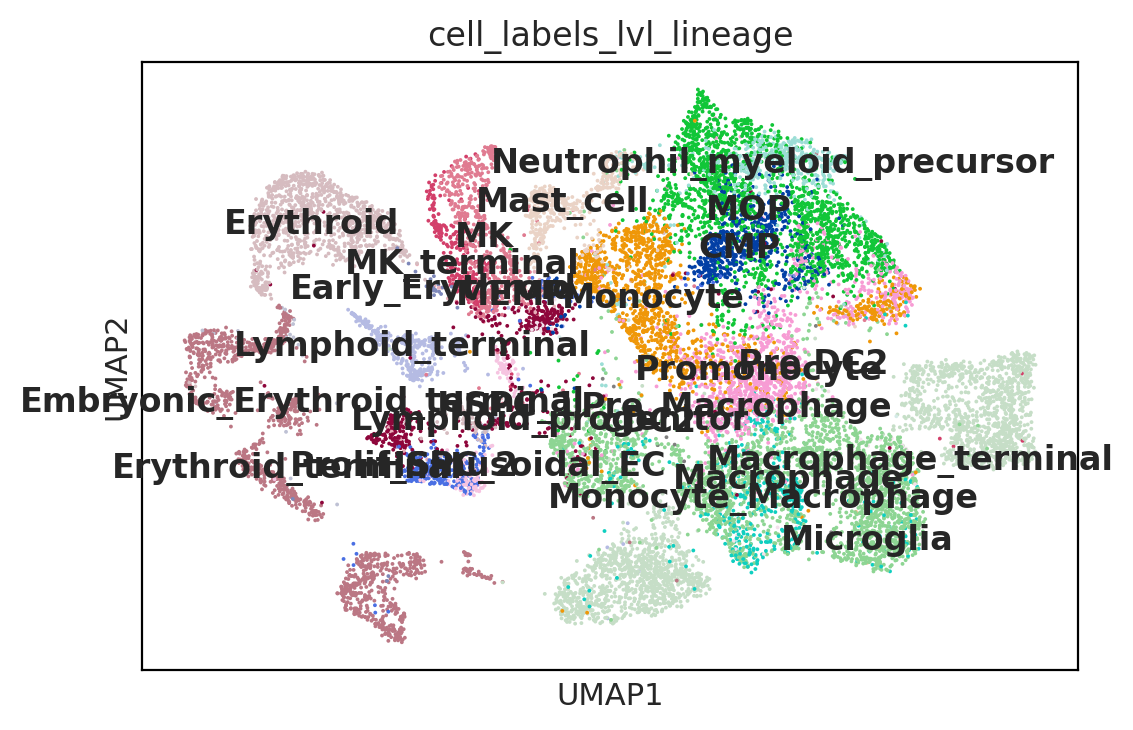

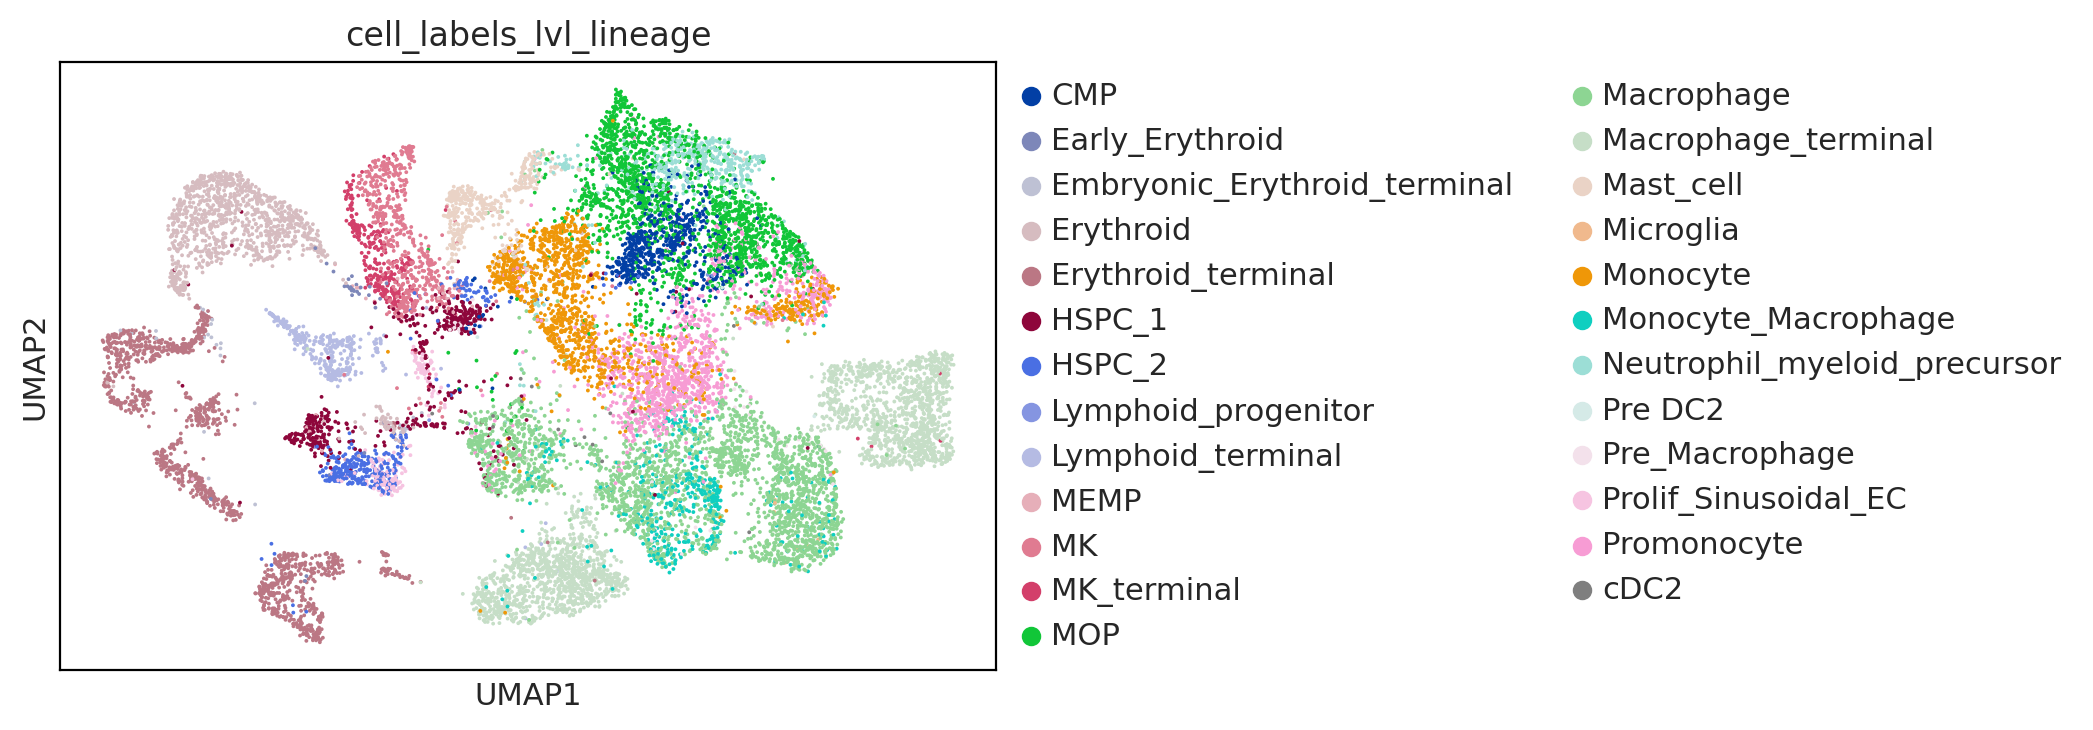

In [33]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=15,use_rep = 'X_scvi',copy=False)
# sc.tl.leiden(adata)
sc.tl.umap(adata)
# sc.tl.draw_graph(adata, layout='fa')
# # sc.tl.leiden(adata, resolution=1)
sc.tl.leiden(adata)
sc.pl.umap(adata,color = ['cell_labels_lvl_lineage'],legend_loc = 'on data')
sc.pl.umap(adata,color = 'cell_labels_lvl_lineage')

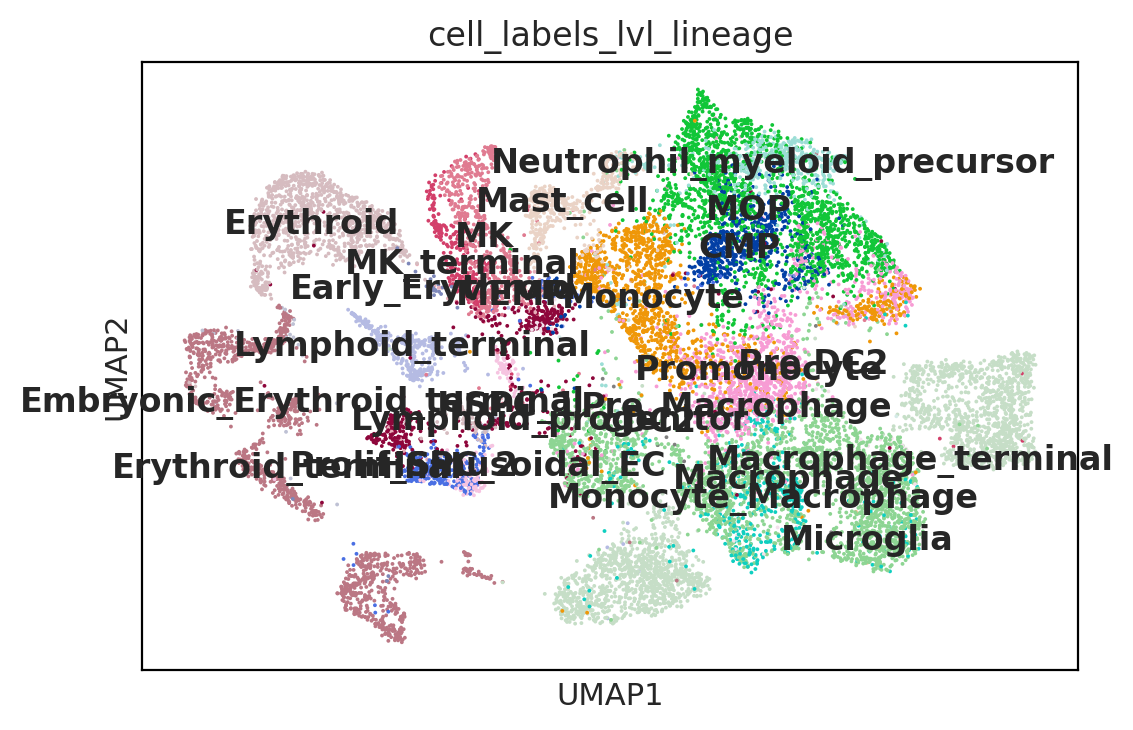

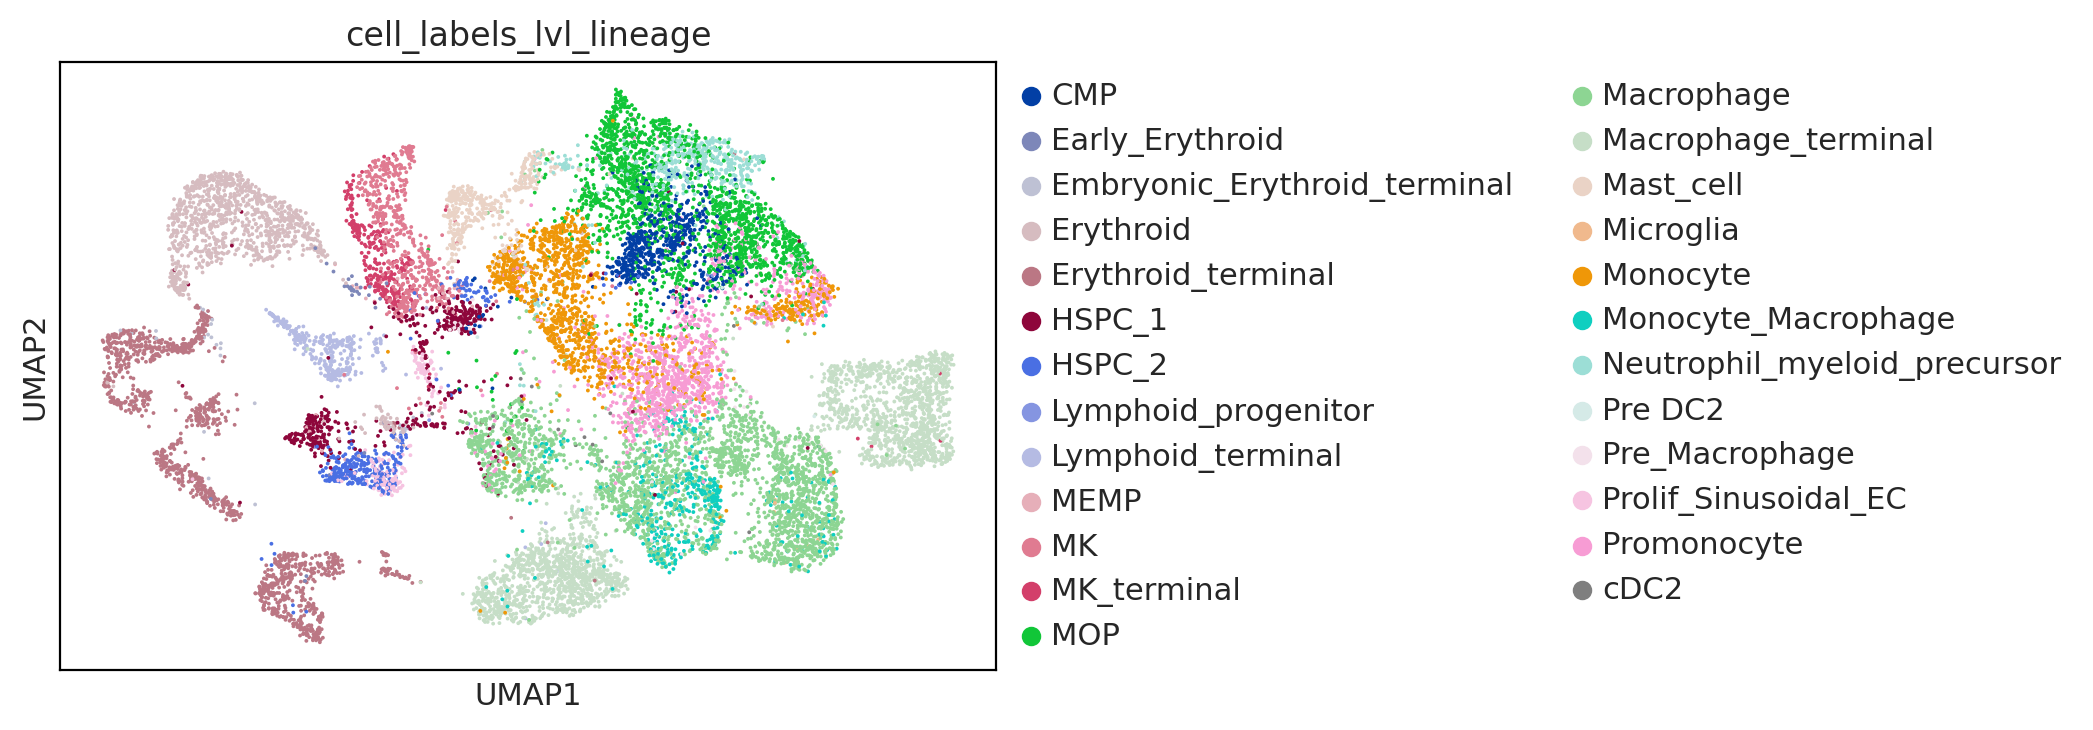

In [35]:
sc.pl.umap(adata,color = ['cell_labels_lvl_lineage'],legend_loc = 'on data')
sc.pl.umap(adata,color = 'cell_labels_lvl_lineage')

This detected 10000 highly variable genes. 
Normalized count data: X.
computing moments based on connectivities
    finished (0:00:06) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Computing CytoTRACE score with `10000` genes
Adding `adata.obs['ct_score']`
       `adata.obs['ct_pseudotime']`
       `adata.obs['ct_num_exp_genes']`
       `adata.var['ct_gene_corr']`
       `adata.var['ct_correlates']`
       `adata.uns['ct_params']`
    Finish (0:00:01)
Computing transition matrix based on `ct_pseudotime`



    Finish (0:00:10)
Projecting transition matrix onto `umap`
Adding `adata.obsm['T_fwd_umap']`
    Finish (0:00:06)


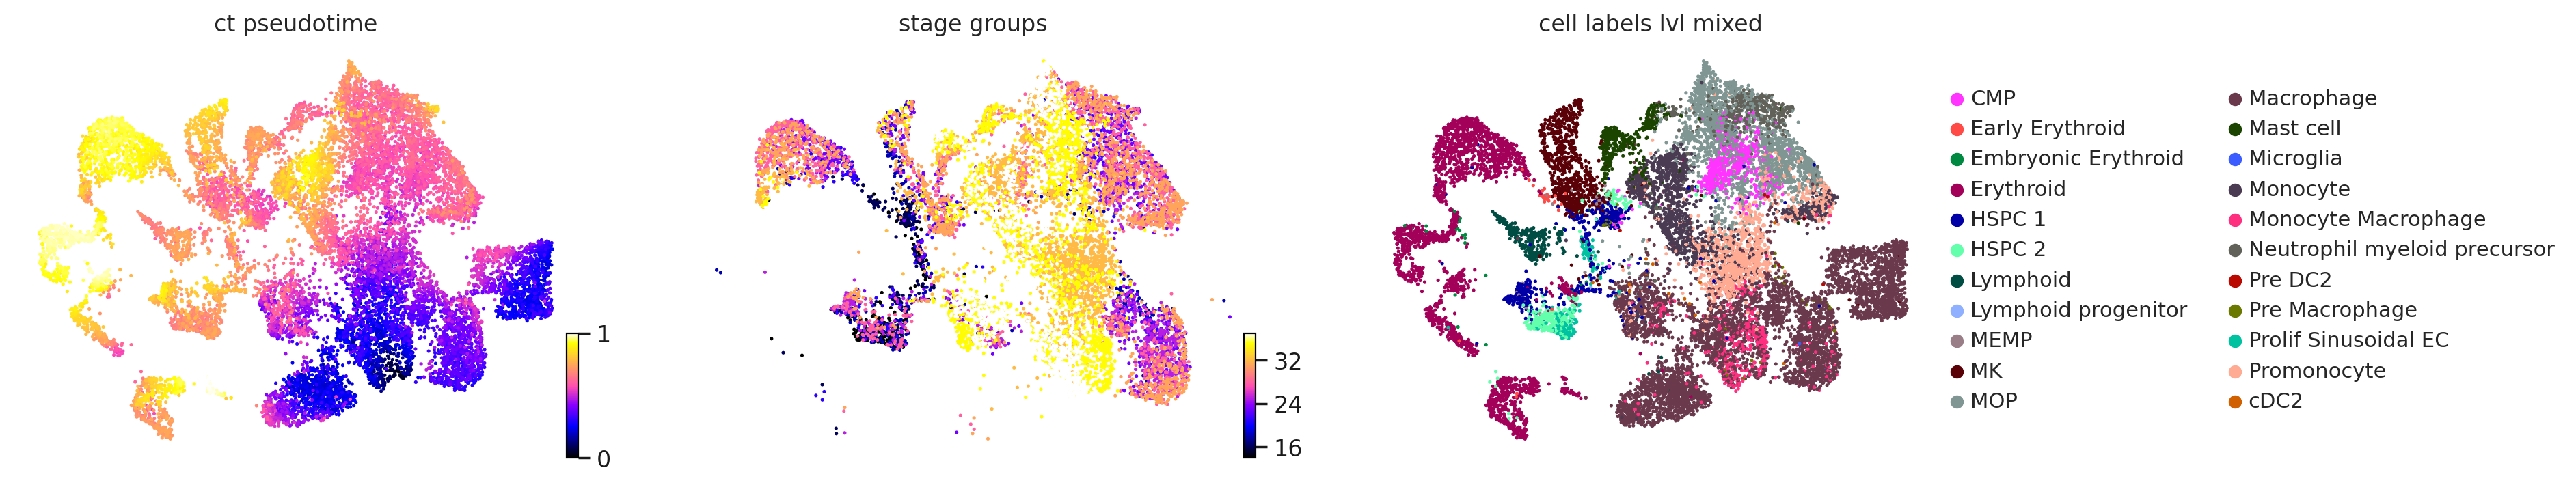

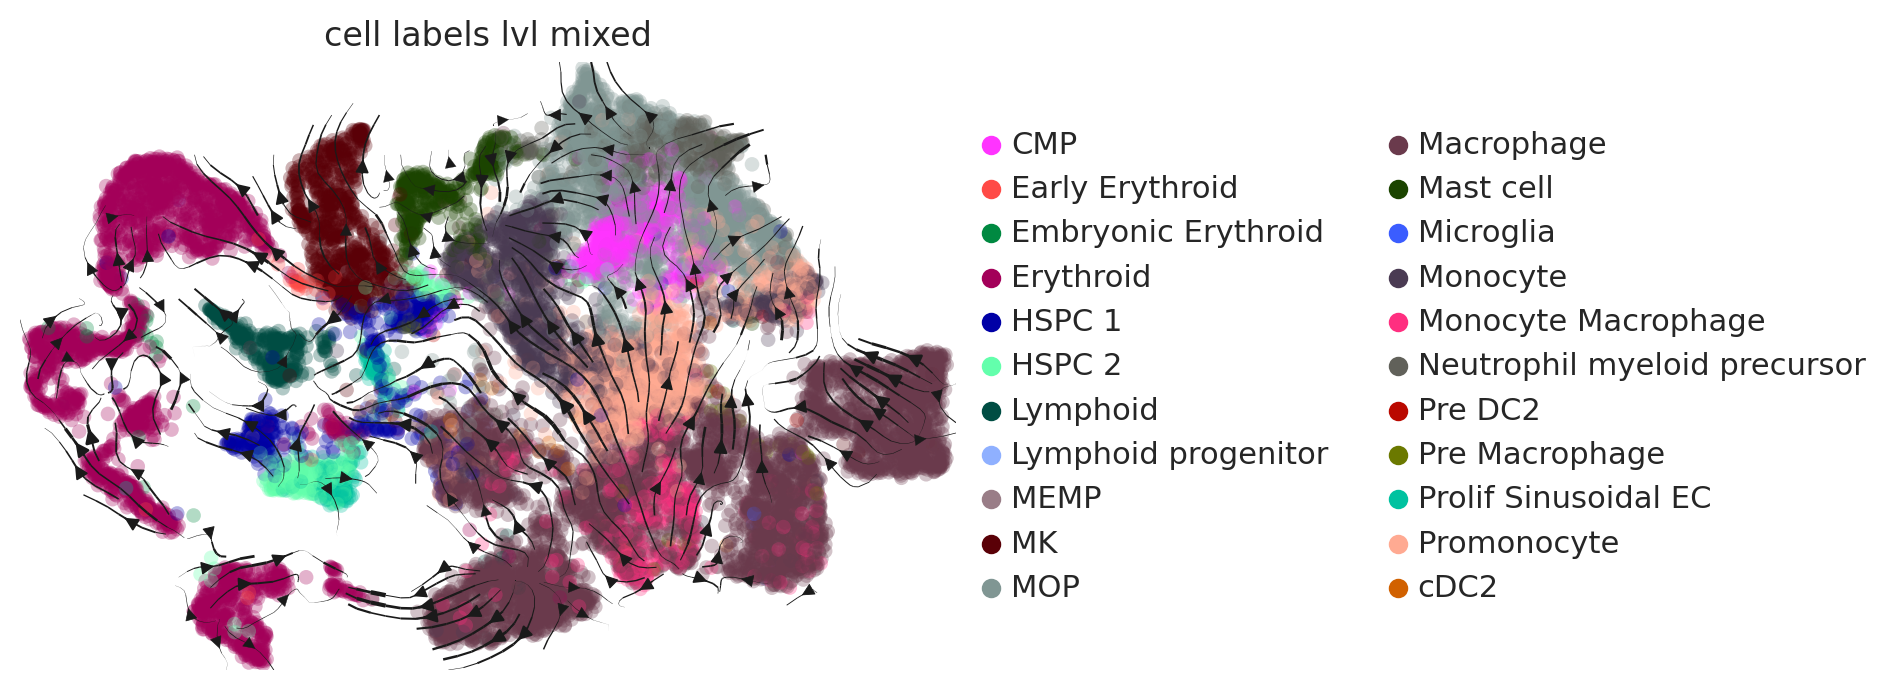

In [36]:
adata.var['highly_variable']=True

print(f"This detected {np.sum(adata.var['highly_variable'])} highly variable genes. ")
# use scVelo's `moments` function for imputation - note that hack we're using here:
# we're copying our `.X` matrix into the layers because that's where `scv.tl.moments`
# expects to find counts for imputation
adata.layers["spliced"] = adata.X
adata.layers["unspliced"] = adata.X
scv.pp.moments(adata, n_pcs=20, n_neighbors=20,use_rep='X_scvi')

##########################################################################

from cellrank.tl.kernels import CytoTRACEKernel
ctk = CytoTRACEKernel(adata)
ctk.compute_transition_matrix(threshold_scheme="soft", nu=0.5)
ctk.compute_projection(basis="umap")

scv.pl.scatter(
adata,
c=["ct_pseudotime", "stage_groups","cell_labels_lvl_mixed"],
basis="umap",
legend_loc="right",
color_map="gnuplot2"
)
scv.pl.velocity_embedding_stream(
adata, color="cell_labels_lvl_mixed", vkey="T_fwd", basis="umap", legend_loc="right"
)

In [37]:
# sc.tl.paga(adata, groups='cell_labels_lvl_mixed', use_rna_velocity=False, model='v1.2', neighbors_key=None, copy=False)
# sc.pl.paga(adata)
# sc.tl.draw_graph(adata, layout='fa',init_pos='paga')
# sc.pl.draw_graph(adata,color= 'cell_labels_lvl_mixed')

GPCCA[n=15825, kernel=<CytoTRACEKernel[dnorm=False, scheme=soft, b=10.0, nu=0.5]>]
Computing Schur decomposition
Mat Object: 1 MPI processes
  type: seqdense
1.0000000000000091e+00 1.4743565608977699e-03 3.9153558770370231e-04 3.5550835695599735e-04 -1.6195184399335164e-03 4.7015257226801343e-03 1.1188111532876666e-03 1.1972731468874427e-02 3.1156788786595589e-03 5.3944867999948147e-03 -1.0264174366606871e-02 6.8348444907288773e-03 8.1283452724781914e-03 -1.3415858582061806e-03 -1.3279153430119366e-02 
0.0000000000000000e+00 9.9920354230097863e-01 -5.6267087066611043e-05 5.4684472864749705e-04 -1.4951404677525462e-03 7.5759598263683021e-04 2.0302253817831312e-03 -4.8478056312905799e-03 -1.0941285709486627e-03 -2.5561447052208025e-03 -9.5174118753512602e-03 -4.9477631079847964e-03 -5.4469598208572532e-03 6.5697171748144514e-04 7.9806324355455056e-03 
0.0000000000000000e+00 0.0000000000000000e+00 9.9904916910727926e-01 2.7051067652944722e-04 -4.5084465048702150e-04 4.1786675989851220e-04

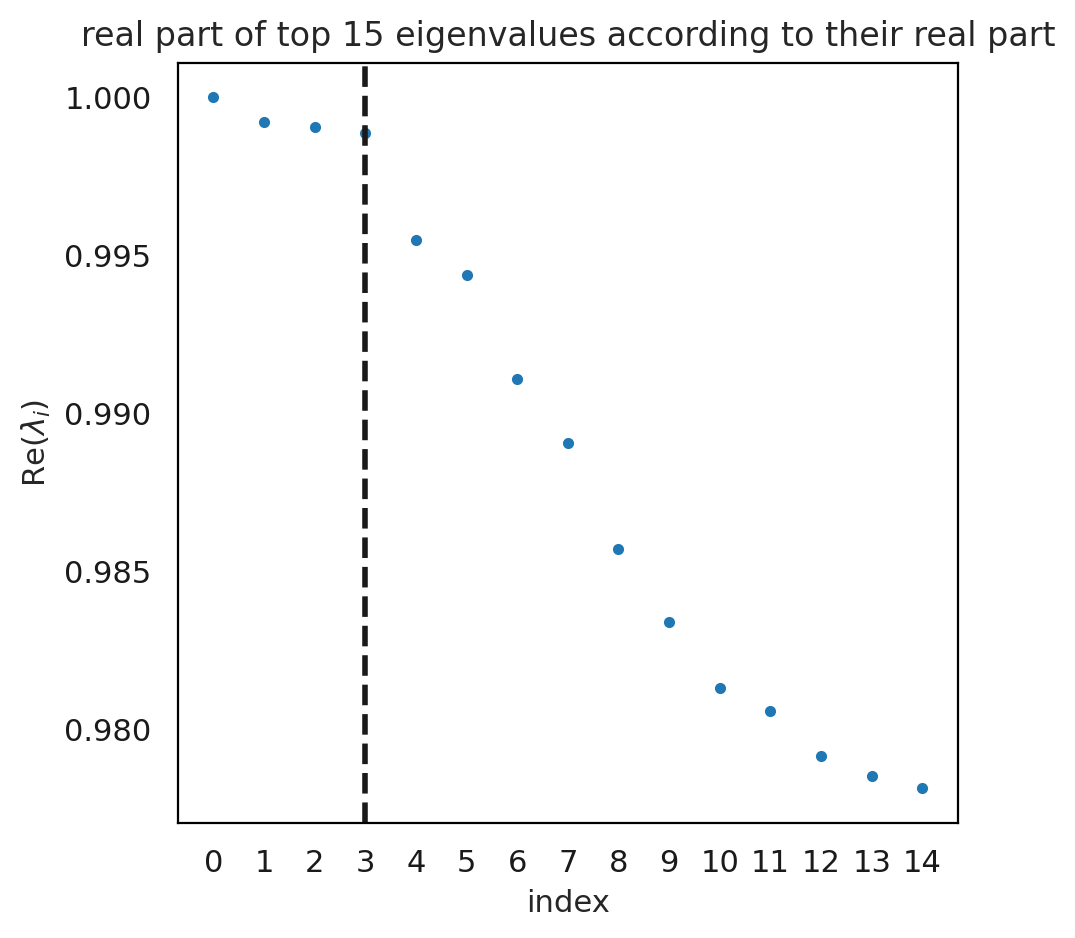

In [38]:
from cellrank.tl.estimators import GPCCA
g_fwd = GPCCA(ctk)
print(g_fwd)
g_fwd.compute_schur(n_components=15, method= 'krylov') #method='brandts is true schur distribution but will not scale
g_fwd.plot_spectrum(real_only=True)

Adding `adata.obs['terminal_states']`
       `adata.obs['terminal_states_probs']`
       `.terminal_states`
       `.terminal_states_probabilities`
       `.terminal_states_memberships
    Finish`


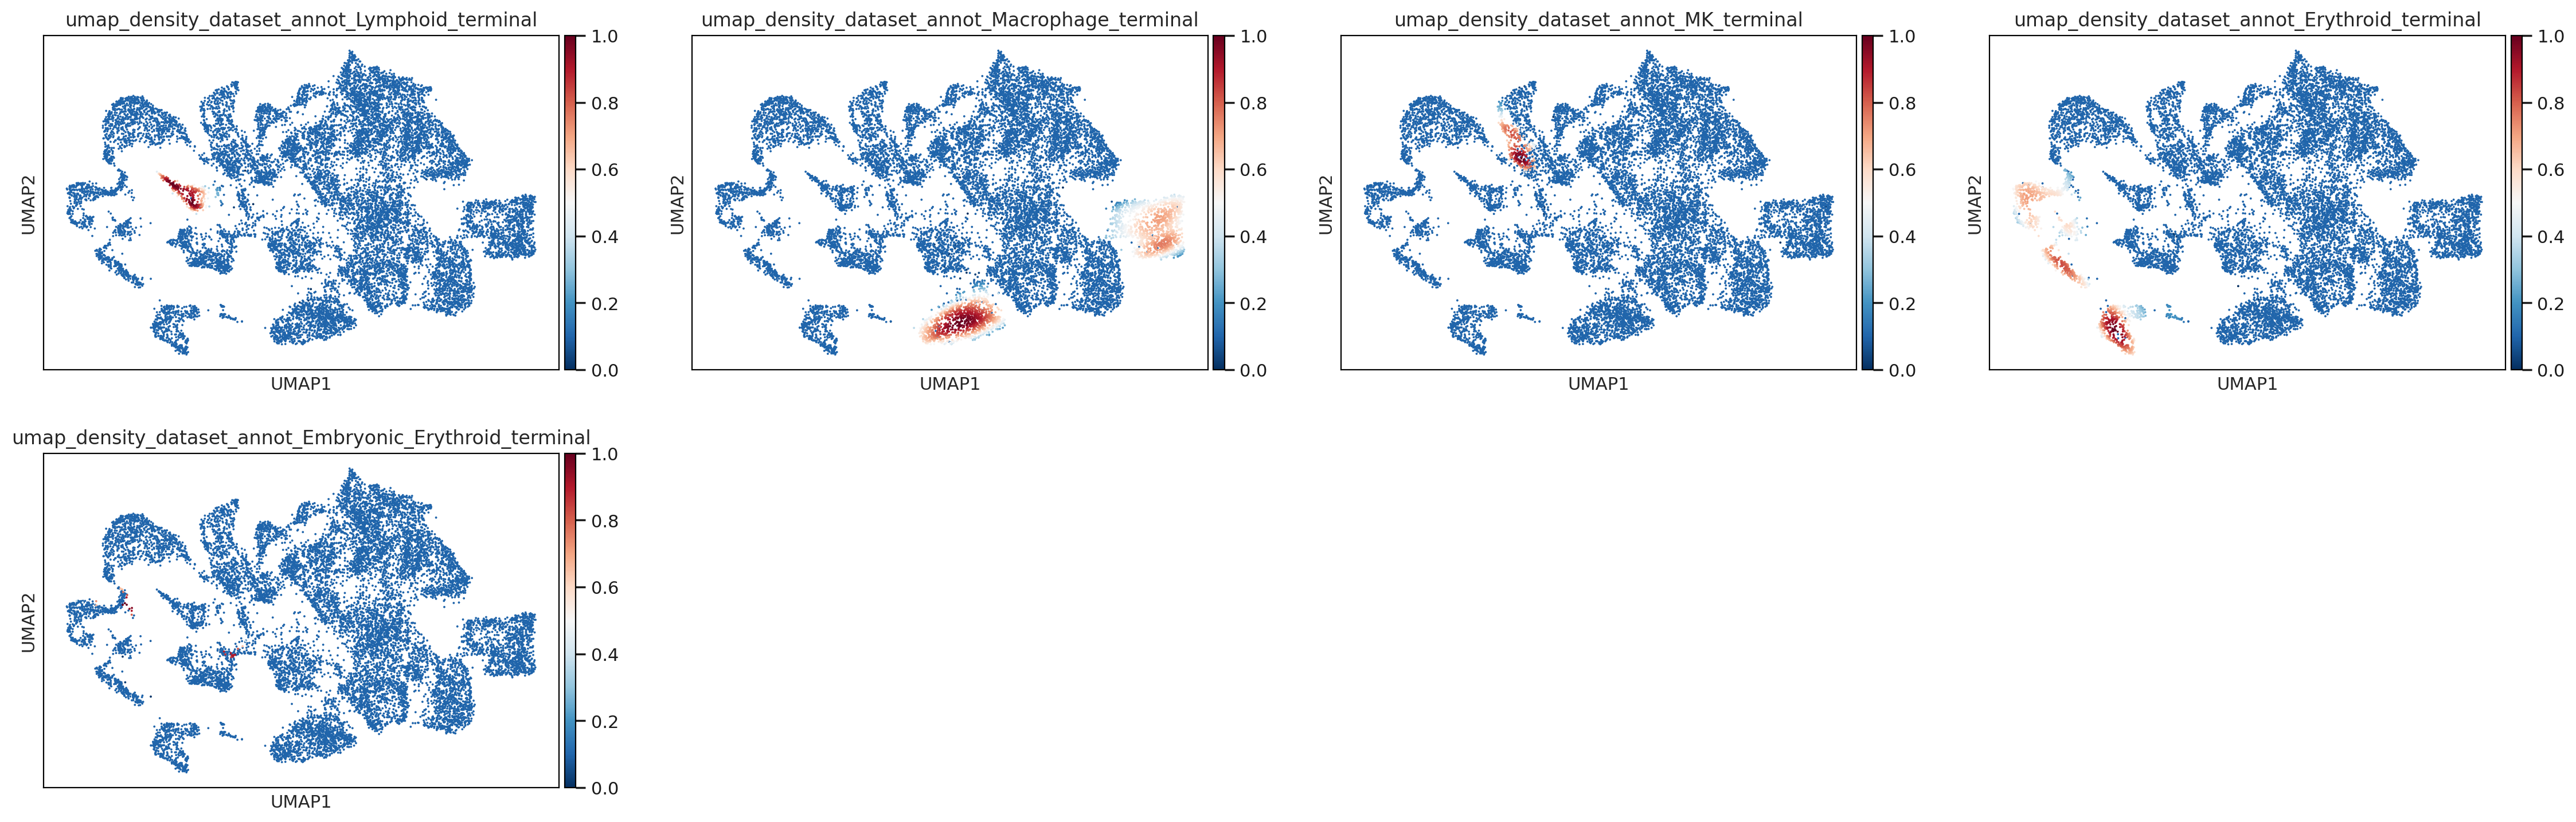

In [42]:
var_group = 'cell_labels_lvl_lineage'
sc.tl.embedding_density(adata, basis='umap', groupby=var_group, key_added='umap_density_dataset_annot')
macro = {}
state_init = [
 'Lymphoid_terminal',
     'Macrophage_terminal',
         'MK_terminal',
             'Erythroid_terminal',
     'Embryonic_Erythroid_terminal',
]
densities = []
for i in state_init:
    # find KDE center of density for each state
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs[var_group].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1
    macro[i] = adata.obs.index[adata.obs.index.isin(adata.obs['umap_density_dataset_annot_'+i].nlargest(30).index)]
    densities.append('umap_density_dataset_annot_'+i)
    macro[i] = adata[adata.obs["cell_labels_lvl_lineage"] == i].obs_names
g_fwd.set_terminal_states(macro)
sc.pl.umap(adata,color = densities)

In [43]:
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_lineage'].str.replace('_1','')
adata.obs['cell_labels_lvl_lineage'] = adata.obs['cell_labels_lvl_lineage'].str.replace('_2','')

In [44]:
list(adata.obs['cell_labels_lvl_lineage'].unique())

['Macrophage_terminal',
 'MK_terminal',
 'Erythroid_terminal',
 'Lymphoid_terminal',
 'Embryonic_Erythroid_terminal',
 'HSPC',
 'Prolif_Sinusoidal_EC',
 'Erythroid',
 'Early_Erythroid',
 'Lymphoid_progenitor',
 'CMP',
 'MEMP',
 'Macrophage',
 'Monocyte_Macrophage',
 'Microglia',
 'Neutrophil_myeloid_precursor',
 'Monocyte',
 'Promonocyte',
 'MOP',
 'MK',
 'Mast_cell',
 'cDC2',
 'Pre_Macrophage',
 'Pre DC2']

In [46]:
pd.set_option('display.max_rows', 321)
adata.obs.groupby(['stage_groups','cell_labels_lvl_lineage']).apply(len)

stage_groups  cell_labels_lvl_lineage     
14.0          Early_Erythroid                   3
              Erythroid                         6
              HSPC                            194
              Lymphoid_progenitor               2
              MEMP                              2
              MK                               16
              Prolif_Sinusoidal_EC             60
16.0          CMP                               4
              Early_Erythroid                  24
              Erythroid                        31
              HSPC                             36
              MEMP                              5
              MK                               64
              Prolif_Sinusoidal_EC             31
18.0          CMP                              25
              Erythroid                        14
              HSPC                             79
              MEMP                              1
              MK                               64
       

In [47]:
# list(g_fwd.macrostates.unique())

In [48]:
adata.obsm

AxisArrays with keys: X_scvi, X_umap, _scvi_extra_categorical_covs, T_fwd_umap, schur_vectors_fwd

In [52]:
adata_orig = adata.copy()

In [54]:
g_fwd_orig = g_fwd.copy()
adata_pre_split = adata.copy()

In [126]:
map_state = ['HSPC']

####################

# Compute KDE for pim HSPC
sc.tl.embedding_density(adata, basis='umap', groupby='cell_labels_lvl_lineage', key_added='umap_density_dataset_annot', components=None)
for i in map_state:
    adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
    adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1

# map_state = ['Progenitor']

# ####################

# # Compute KDE for pim HSPC
# sc.tl.embedding_density(adata, basis='umap', groupby='broad_cell.labels', key_added='umap_density_dataset_annot', components=None)
# for i in map_state:
#     adata.obs['umap_density_dataset_annot_'+i] = adata.obs['umap_density_dataset_annot']
#     adata.obs.loc[~adata.obs['cell_labels_lvl_lineage'].isin([i]),('umap_density_dataset_annot_'+i)] = 0.1

/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Informally, given a (finite, discrete) Markov chain with a set of transient states  and a set of absorbing states , the absorption probability for cell  from  to reach cell  from  is the probability that a random walk initialized in  ### will reach absorbing state .

### In our context, states correspond to cells, in particular, absorbing states correspond to cells in terminal states.

In [58]:
#adata.obsm['to_terminal_states'] = g_fwd.absorption_probabilities

In [ ]:
# states = states_inc 
# g_fwd.compute_macrostates(n_states=10, cluster_key="cell_labels_lvl_lineage")
# g_fwd.set_terminal_states_from_macrostates(names=states)
g_fwd.compute_absorption_probabilities(solver='direct')#solver='direct'
g_fwd.plot_absorption_probabilities(same_plot=False, size=50, basis="umap")
adata.obsm['to_terminal_states'] = g_fwd.absorption_probabilities
#cr.pl.circular_projection(adata, keys=["cell_sets", "cell_labels_lvl3"], early_cells={'cell_labels_lvl_lineage':'PRIM_HSPC_1'},lineages = state_init,legend_loc="right", title="")
cr.pl.circular_projection(adata, keys=['umap_density_dataset_annot_HSPC',"cell_labels_lvl_lineage"], lineages = state_init,legend_loc="right", title="",early_cells={'cell_labels_lvl_lineage':'HSPC'}, lineage_order='default', metric='correlation', normalize_by_mean=True,save = 'ipsc_clara' )

In [13]:
state_init = [
'Embryonic_Erythroid_terminal',
'MK_terminal',
'Erythroid_terminal',
#'Embryonic_Erythroid_terminal',
'Lymphoid_terminal',
'Macrophage_terminal',
]

# state_init = [ 'Lymphoid_terminal',
#  'MK_terminal', 
# 'Erythroid_terminal',
#  'Macrophage_terminal',
#  'Embryonic_Erythroid_terminal',]


/home/jovyan/my-conda-envs/workhorse/lib/python3.8/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


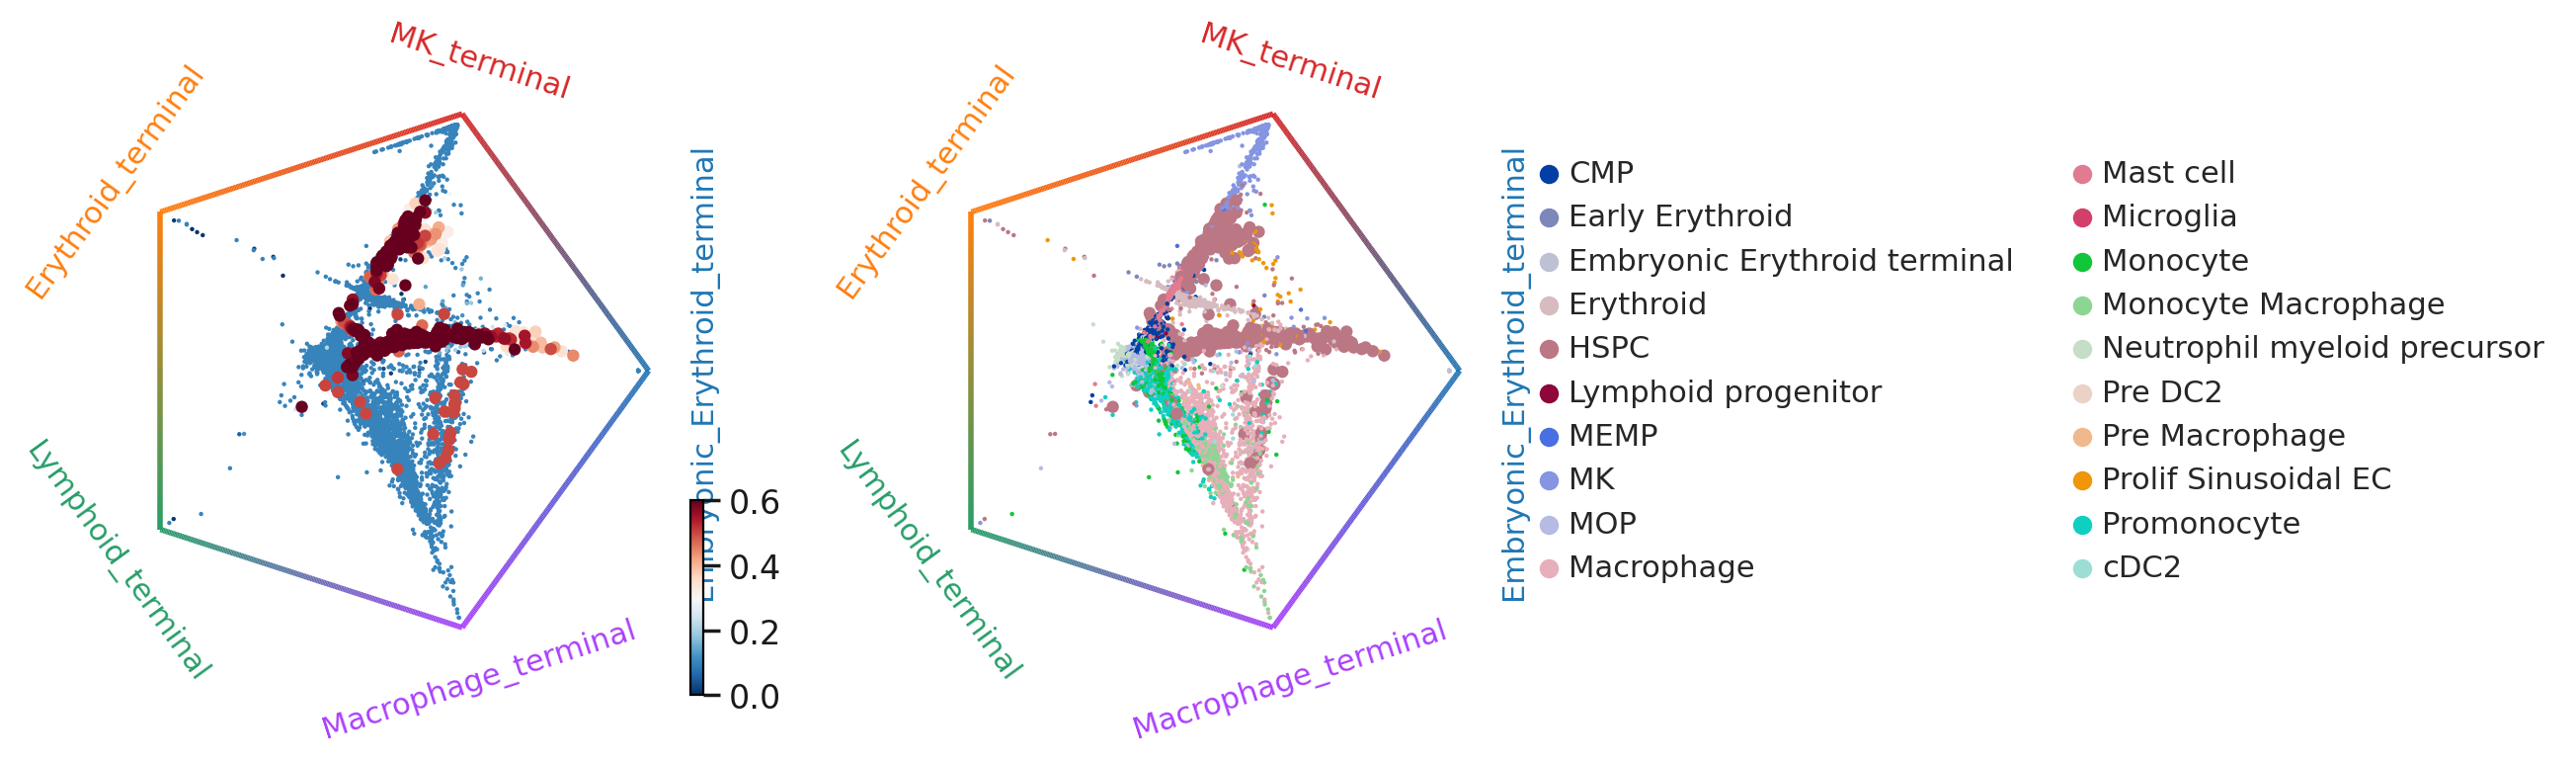

In [223]:
map_state = ['HSPC']
adata.obs['sizes'] =  10
for i in map_state:
    density_cutoff = 0.3
#     adata.obs.loc[adata.obs['umap_density_dataset_annot_HSPC']<density_cutoff,'umap_density_dataset_annot_HSPC'] = 0.1
#     adata.obs.loc[adata.obs['umap_density_dataset_annot_HSPC']>density_cutoff,'umap_density_dataset_annot_HSPC'] = 0.7
    
    adata.obs.loc[adata.obs['umap_density_dataset_annot_HSPC']>=density_cutoff,'sizes'] = 80#(adata.obs.loc[adata.obs['umap_density_dataset_annot_HSPC']>density_cutoff,'umap_density_dataset_annot_HSPC']*200).round(0)
#     adata.obs.loc[adata.obs['cell_labels_lvl_lineage'].isin([i]),'sizes'] = (adata.obs.loc[adata.obs['cell_labels_lvl_lineage'].isin([i]),'umap_density_dataset_annot_PRIM_HSPC']*100).round(0)
cr.pl.circular_projection(adata, keys=['umap_density_dataset_annot_HSPC', "cell_labels_lvl_lineage"], lineages = state_init,legend_loc="right", title="",early_cells={'cell_labels_lvl_lineage':'HSPC'}, lineage_order='default', metric='correlation', normalize_by_mean=True,save = 'Clara_ipsc_prim.pdf',cmap = 'RdBu_r' ,size = np.array(adata.obs['sizes']),vmax = 0.6,vmin = 0)

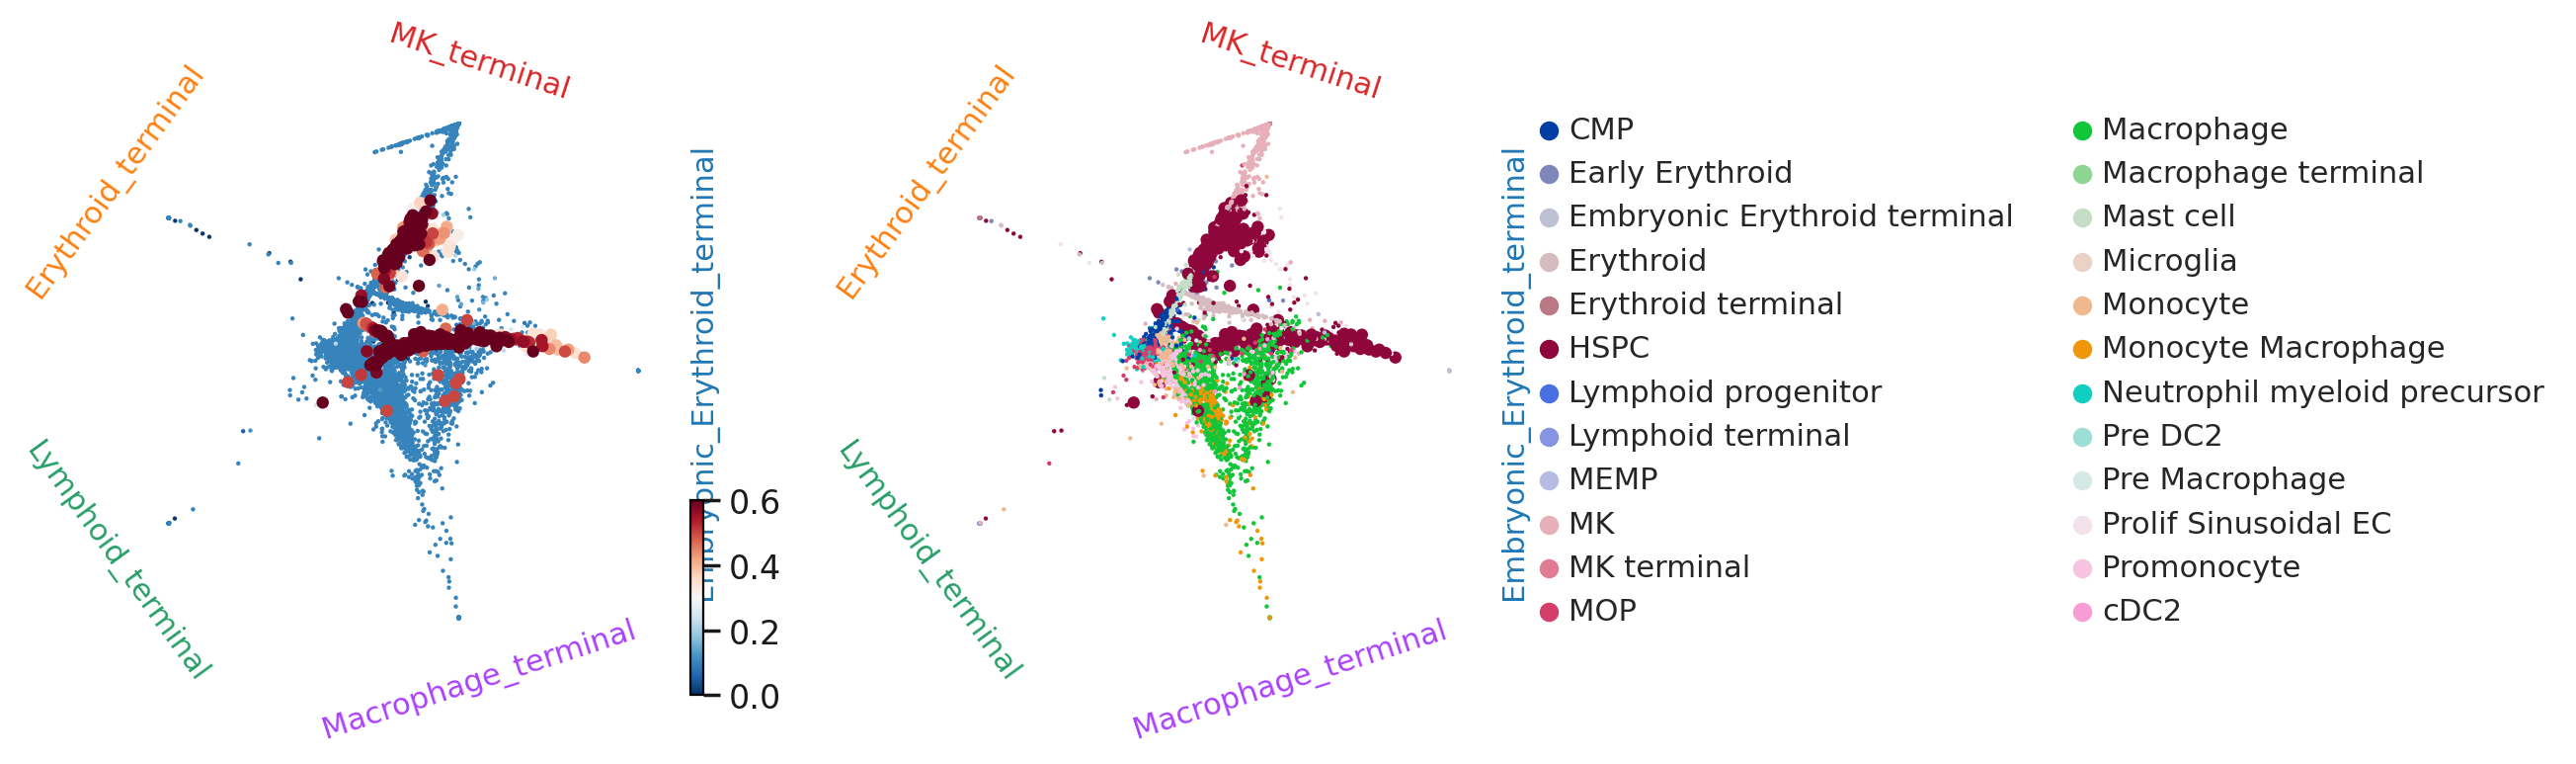

In [14]:
map_state = ['HSPC']
adata.obs['sizes'] =  10
for i in map_state:
    density_cutoff = 0.3
#     adata.obs.loc[adata.obs['umap_density_dataset_annot_HSPC']<density_cutoff,'umap_density_dataset_annot_HSPC'] = 0.1
#     adata.obs.loc[adata.obs['umap_density_dataset_annot_HSPC']>density_cutoff,'umap_density_dataset_annot_HSPC'] = 0.7
    
    adata.obs.loc[adata.obs['umap_density_dataset_annot_HSPC']>=density_cutoff,'sizes'] = 80#(adata.obs.loc[adata.obs['umap_density_dataset_annot_HSPC']>density_cutoff,'umap_density_dataset_annot_HSPC']*200).round(0)
#     adata.obs.loc[adata.obs['cell_labels_lvl_lineage'].isin([i]),'sizes'] = (adata.obs.loc[adata.obs['cell_labels_lvl_lineage'].isin([i]),'umap_density_dataset_annot_PRIM_HSPC']*100).round(0)
cr.pl.circular_projection(adata, show_edges=False,keys=['umap_density_dataset_annot_HSPC', "cell_labels_lvl_lineage"], lineages = state_init,legend_loc="right", title="",early_cells={'cell_labels_lvl_lineage':'HSPC'}, lineage_order='default', metric='correlation', normalize_by_mean=True,save = 'Clara_ipsc_prim_V3.pdf',cmap = 'RdBu_r' ,size = np.array(adata.obs['sizes']),vmax = 0.6,vmin = 0)